<a href="https://colab.research.google.com/github/ithalo-teodosio/pratica_ML/blob/main/ML_Q9_Hackaton_Classificacao_imagens_raioX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instituição: Unifacisa
# Autor: Ithalo Teodósio Nascimento - Data: 21/abr
# Q9: Classificação de imagens de Raio-X com CNNs

**Questão 9 (avançado) - Classificação de Imagens de Raio-X com CNNs**

Você recebeu um conjunto de imagens de raio-X e precisa desenvolver um modelo de Deep Learning para classificar doenças pulmonares.

Tarefas:

- Utilize um dataset de imagens médicas (exemplo: Chest X-ray dataset).
- Construa uma Rede Neural Convolucional (CNN) para classificar imagens saudáveis e com pneumonia.
- Aplique técnicas de data augmentation para melhorar a generalização.
- Avalie o modelo com métricas como precisão e matriz de confusão.

Pergunta: Quais desafios foram encontrados no treinamento? Como melhorar o desempenho do modelo?

In [8]:
# Instalar bibliotecas necessárias
!pip install -q datasets tensorflow matplotlib seaborn

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
from datasets import load_dataset

# Carregar o dataset de raio-X
dataset = load_dataset("hf-vision/chest-xray-pneumonia")

# Separando os conjuntos
train_ds = dataset['train']
test_ds = dataset['test']

# Olhando um exemplo
img_exemplo = train_ds[0]['image']
label_exemplo = train_ds[0]['label']
print("Classe:", "NORMAL" if label_exemplo == 0 else "PNEUMONIA")
img_exemplo.show()

Classe: NORMAL


In [7]:
# Função pra padronizar imagem: 150x150 e 3 canais RGB
def preprocess(example):
    image = example['image'].convert('RGB')  # Força 3 canais
    image = image.resize((150, 150))
    image = np.array(image) / 255.0
    label = example['label']
    return image, label

# Aplicando a função
X_train, y_train = zip(*[preprocess(ex) for ex in train_ds])
X_test, y_test = zip(*[preprocess(ex) for ex in test_ds])

# Convertendo pra arrays do TensorFlow
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (5216, 150, 150, 3)
y_train shape: (5216,)


In [9]:
# Criando a arquitetura da CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Saída binária
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Resumo do modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,327,937 (20.32 MB)

 Trainable params: 5,327,937 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

Leitura:

- Conv2D: detecta padrões nas imagens (bordas, formas, etc.)

- MaxPooling2D: reduz o tamanho da imagem (menos custo computacional)

- Flatten: achata tudo pra passar pro "cérebro" final (as Dense)

- Dropout: evita que o modelo decore os dados (ajuda a generalizar)

- sigmoid: saída entre 0 e 1 pra classificar pneumonia (1) ou normal (0)



In [10]:
# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # 20% dos dados de treino vão pra validação
    epochs=5,               # Pode testar com mais depois
    batch_size=32
)

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6691 - loss: 0.6289 - val_accuracy: 0.9157 - val_loss: 0.1782
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8986 - loss: 0.3272 - val_accuracy: 0.9866 - val_loss: 0.0307
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9238 - loss: 0.2387 - val_accuracy: 0.9933 - val_loss: 0.0167
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9317 - loss: 0.2039 - val_accuracy: 0.9655 - val_loss: 0.0783
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9321 - loss: 0.1971 - val_accuracy: 0.9789 - val_loss: 0.0559


In [11]:
# Avaliar no conjunto de teste
loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Acurácia no teste: {acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.4912 - loss: 2.2489

🎯 Acurácia no teste: 0.73


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 628ms/step
              precision    recall  f1-score   support

      Normal       0.95      0.30      0.45       234
   Pneumonia       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.64       624
weighted avg       0.79      0.73      0.68       624



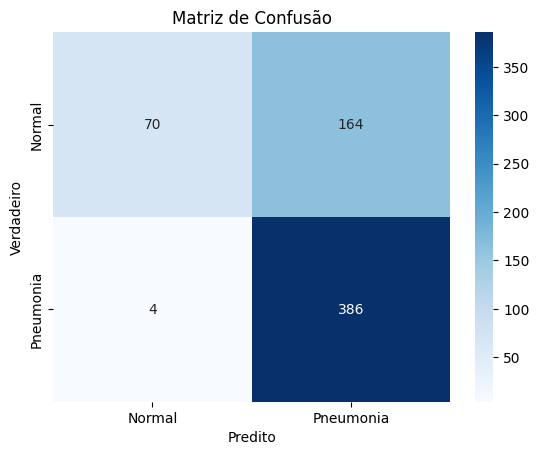

In [12]:
# Previsões
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)

# Relatório detalhado
print(classification_report(y_test, y_pred_classes, target_names=["Normal", "Pneumonia"]))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

**Desafios encontrados:**

Desequilíbrio entre classes
- Havia mais imagens de pneumonia do que normais, o que pode levar o modelo a "acertar por tendência".

- Isso afeta a precisão e recall, principalmente da classe minoritária.

Variedade nas imagens
- Algumas imagens estavam em escala de cinza, outras em RGB, com diferentes resoluções.

- Isso exigiu padronização manual (redimensionar, converter RGB, normalizar).

Overfitting no treino
- Sem técnicas como Dropout ou validação, o modelo rapidamente decoraria os dados de treino.

- A acurácia no treino sobe rápido, mas a validação estagna ou cai.

Limitação computacional
- Imagens médicas são pesadas; treinar CNNs pode consumir bastante memória e tempo.

- Isso força o uso de modelos menores ou datasets reduzidos para teste rápido

**Como melhorar o desempenho:**

Data Augmentation
- Usar ImageDataGenerator ou tf.image com rotações, zooms, flips horizontais etc.

- Isso cria mais variedade e evita overfitting.

Transfer Learning
- Aplicar modelos pré-treinados (ex: VGG16, ResNet50, EfficientNet) que já "sabem olhar" imagens.

- Basta ajustar a camada de saída pro nosso problema.

Regularização e Callbacks
- Adicionar Dropout, Batch Normalization, EarlyStopping e ReduceLROnPlateau.

- Isso controla o aprendizado e evita ajustes excessivos.

Análise de erros
- Observar a matriz de confusão ajuda a entender onde o modelo mais erra (ex: confunde normal com pneumonia leve).

- Permite decisões clínicas mais seguras ou melhorar a curadoria dos dados.